In [305]:
import torch
import numpy as np
import pandas as pd
import math
import random
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.datasets import DBLP
from torch_geometric.nn import HGTConv, Linear
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

In [272]:
def seed_everything(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

seed_everything(42)

Random seed set as 42


In [273]:
device = 'cpu'
feature_index = 0

In [274]:
# best_config = {'lr': 0.001,
#  'weight_decay': 0.005,
#  'epochs': 200,
#  'train_ratio': 0.8,
#  'val_ratio': 0.1,
#  'test_ratio': 0.1,
#  'hidden_channels': 64,
#  'num_heads': 4,
#  'num_layers': 2}

In [326]:
config = dict()
config["lr"] = 0.001
config["weight_decay"] = 5e-3
config["epochs"] = 200
config['train_ratio'] = 0.8
config['val_ratio'] = 0.1
config['test_ratio'] = 0.1
config['hidden_channels'] = 64
config['num_heads'] = 4
config['num_layers'] = 2
config

{'lr': 0.001,
 'weight_decay': 0.005,
 'epochs': 200,
 'train_ratio': 0.8,
 'val_ratio': 0.1,
 'test_ratio': 0.1,
 'hidden_channels': 64,
 'num_heads': 4,
 'num_layers': 2}

### Loading everything

In [327]:
patient_features = torch.tensor(np.load('data/Processed/patient_features.npy')).to(torch.float32)
procedure_features = torch.tensor(np.load('data/Processed/procedure_features.npy')).to(torch.float32)
medication_features = torch.tensor(np.load('data/Processed/medication_features.npy')).to(torch.float32)
lab_features = torch.tensor(np.load('data/Processed/lab_features.npy')).to(torch.float32)

patient_edges = torch.tensor(np.load('data/Processed/patient_edges.npy'))
procedure_edges = torch.tensor(np.load('data/Processed/procedures_edges.npy'))
medication_edges = torch.tensor(np.load('data/Processed/medication_edges.npy'))
lab_edges = torch.tensor(np.load('data/Processed/lab_edges.npy'))

labels = torch.tensor(np.load('data/Processed/MIMIC_y.npy')[:, feature_index]).to(torch.float32)

In [336]:
num_patient_nodes = len(patient_features)
num_train_nodes = int(config['train_ratio'] * num_patient_nodes)
num_val_nodes = int(config['val_ratio'] * num_patient_nodes)
num_test_nodes = num_patient_nodes - num_train_nodes - num_val_nodes

# patient_nodes_indices = torch.arange(num_patient_nodes)
# shuffled_indices = torch.randperm(num_patient_nodes)

patient_nodes_indices = np.arange(num_patient_nodes)
np.random.shuffle(patient_nodes_indices)
shuffled_indices = torch.tensor(patient_nodes_indices)

train_indices = shuffled_indices[:num_train_nodes]
val_indices = shuffled_indices[num_train_nodes:num_train_nodes + num_val_nodes]
test_indices = shuffled_indices[num_train_nodes + num_val_nodes:]

train_mask = torch.zeros(num_patient_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_patient_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_patient_nodes, dtype=torch.bool)

train_mask[patient_nodes_indices[train_indices]] = True
val_mask[patient_nodes_indices[val_indices]] = True
test_mask[patient_nodes_indices[test_indices]] = True

print(len(train_mask), train_mask[:10])
print(len(val_mask), val_mask[:10])
print(len(test_mask), test_mask[:10])

1483 tensor([False, False,  True,  True,  True,  True,  True,  True,  True, False])
1483 tensor([ True,  True, False, False, False, False, False, False, False,  True])
1483 tensor([False, False, False, False, False, False, False, False, False, False])


In [337]:
data = HeteroData()

data['patient'].x = patient_features
data['patient'].y = labels
data['patient'].train_mask = train_mask
data['patient'].val_mask = val_mask
data['patient'].test_mask = test_mask
data['procedure'].x = procedure_features
data['medication'].x = medication_features
data['lab'].x = lab_features

data['patient', 'same_patient', 'patient'].edge_index = patient_edges
data['patient', 'proc_values', 'procedure'].edge_index = procedure_edges
data['patient', 'med_values', 'medication'].edge_index = medication_edges
data['patient', 'lab_values', 'lab'].edge_index = lab_edges

data = T.ToUndirected()(data)
# data = T.AddSelfLoops()(data)
# data = T.NormalizeFeatures()(data)

data = data.to(device)

print(data.has_isolated_nodes(), data.has_self_loops(), data.is_undirected())

False False True


In [338]:
print(len(procedure_features))
print(len(medication_features))
print(len(lab_features))

93
277
1051


In [339]:
class HGT(torch.nn.Module):
    
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers, num_pat, num_proc, num_med, num_lab):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
#         for node_type in data.node_types:
#             self.lin_dict[node_type] = Linear(-1, hidden_channels)
        self.lin_dict["patient"] = Linear(num_pat, hidden_channels)
        self.lin_dict["procedure"] = Linear(num_proc, hidden_channels)
        self.lin_dict["medication"] = Linear(num_med, hidden_channels)
        self.lin_dict["lab"] = Linear(num_lab, hidden_channels)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data.metadata(),
                           num_heads, group='sum')
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for node_type, x in x_dict.items():
            x_dict[node_type] = self.lin_dict[node_type](x).relu_()

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        out = self.lin(x_dict['patient'])
        out = F.sigmoid(out)
        return out

model = HGT(hidden_channels=64, out_channels=1, num_heads=2, num_layers=2, 
            num_pat=3, num_proc=len(procedure_features), num_med=len(medication_features), 
            num_lab=len(lab_features)).to(device)
print(model)

HGT(
  (lin_dict): ModuleDict(
    (patient): Linear(3, 64, bias=True)
    (procedure): Linear(93, 64, bias=True)
    (medication): Linear(277, 64, bias=True)
    (lab): Linear(1051, 64, bias=True)
  )
  (convs): ModuleList(
    (0-1): 2 x HGTConv(-1, 64, heads=2)
  )
  (lin): Linear(64, 1, bias=True)
)


In [340]:
losses = []
auprc_val = []
auprc_test = []
auprc_train = []
acc_val = []
acc_test = []
acc_train = []

with torch.no_grad():
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['patient'].train_mask
    loss = F.cross_entropy(out[mask].squeeze(), data['patient'].y[mask])
    loss.backward()
    optimizer.step()
    train_acc = ((out[mask].detach().cpu().numpy().squeeze()>0.5).astype(int) == data['patient'].y[mask].detach().cpu().numpy()).sum()/len(out[mask])
    precision, recall, thresholds = precision_recall_curve(data["patient"].y[mask].cpu().numpy(), out[mask].squeeze().detach().cpu().numpy())
    train_auprc = auc(recall, precision)
    return train_acc, train_auprc, float(loss)

@torch.no_grad()
def test():
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)
    val_mask = data['patient'].val_mask
    precision, recall, thresholds = precision_recall_curve(data["patient"].y[val_mask].cpu().numpy(), out[val_mask].squeeze().detach().cpu().numpy())
    val_auprc = auc(recall, precision)
    test_mask = data['patient'].test_mask
    precision, recall, thresholds = precision_recall_curve(data["patient"].y[test_mask].cpu().numpy(), out[test_mask].squeeze().detach().cpu().numpy())
    test_auprc = auc(recall, precision)
    val_acc = ((out[val_mask].detach().cpu().numpy().squeeze()>0.5).astype(int) == data['patient'].y[val_mask].detach().cpu().numpy()).sum()/len(out[val_mask])
    test_acc = ((out[test_mask].detach().cpu().numpy().squeeze()>0.5).astype(int) == data['patient'].y[test_mask].detach().cpu().numpy()).sum()/len(out[test_mask])
    
    return (val_auprc, test_auprc, val_acc, test_acc)


for epoch in range(1, config["epochs"]):
    train_acc, train_auprc, loss = train()
    val_auprc, test_auprc, val_acc, test_acc = test()
    losses.append(loss)
    auprc_train.append(train_auprc)
    acc_train.append(train_acc)
    auprc_val.append(val_auprc)
    acc_val.append(val_acc)
    auprc_test.append(test_auprc)
    acc_test.append(test_acc)
    print(f'{epoch:03d}, Loss: {loss:.3f}, TrPRC: {train_auprc:.3f}, TrAcc: {train_acc:.3f}, VaPRC: {val_auprc:.3f}, VaAcc: {val_acc:.3f}, TePRC: {test_auprc:.3f}, TeAcc: {test_acc:.3f}')
    

001, Loss: 5158.298, TrPRC: 0.675, TrAcc: 0.593, VaPRC: 0.710, VaAcc: 0.649, TePRC: 0.661, TeAcc: 0.577
002, Loss: 5156.549, TrPRC: 0.709, TrAcc: 0.613, VaPRC: 0.749, VaAcc: 0.662, TePRC: 0.740, TeAcc: 0.611
003, Loss: 5152.134, TrPRC: 0.731, TrAcc: 0.633, VaPRC: 0.771, VaAcc: 0.669, TePRC: 0.759, TeAcc: 0.624
004, Loss: 5149.923, TrPRC: 0.718, TrAcc: 0.648, VaPRC: 0.747, VaAcc: 0.595, TePRC: 0.709, TeAcc: 0.591
005, Loss: 5146.265, TrPRC: 0.731, TrAcc: 0.652, VaPRC: 0.795, VaAcc: 0.669, TePRC: 0.759, TeAcc: 0.617
006, Loss: 5142.856, TrPRC: 0.738, TrAcc: 0.658, VaPRC: 0.803, VaAcc: 0.669, TePRC: 0.763, TeAcc: 0.617
007, Loss: 5141.234, TrPRC: 0.744, TrAcc: 0.659, VaPRC: 0.782, VaAcc: 0.615, TePRC: 0.750, TeAcc: 0.611
008, Loss: 5138.568, TrPRC: 0.750, TrAcc: 0.649, VaPRC: 0.786, VaAcc: 0.615, TePRC: 0.757, TeAcc: 0.597
009, Loss: 5136.439, TrPRC: 0.759, TrAcc: 0.659, VaPRC: 0.795, VaAcc: 0.662, TePRC: 0.763, TeAcc: 0.617
010, Loss: 5136.959, TrPRC: 0.764, TrAcc: 0.661, VaPRC: 0.807, V

080, Loss: 5050.111, TrPRC: 0.873, TrAcc: 0.842, VaPRC: 0.847, VaAcc: 0.757, TePRC: 0.781, TeAcc: 0.705
081, Loss: 5057.487, TrPRC: 0.874, TrAcc: 0.825, VaPRC: 0.838, VaAcc: 0.709, TePRC: 0.833, TeAcc: 0.711
082, Loss: 5063.839, TrPRC: 0.866, TrAcc: 0.814, VaPRC: 0.847, VaAcc: 0.764, TePRC: 0.804, TeAcc: 0.745
083, Loss: 5047.623, TrPRC: 0.872, TrAcc: 0.846, VaPRC: 0.851, VaAcc: 0.750, TePRC: 0.763, TeAcc: 0.758
084, Loss: 5055.614, TrPRC: 0.871, TrAcc: 0.831, VaPRC: 0.837, VaAcc: 0.682, TePRC: 0.836, TeAcc: 0.745
085, Loss: 5064.713, TrPRC: 0.870, TrAcc: 0.802, VaPRC: 0.852, VaAcc: 0.757, TePRC: 0.789, TeAcc: 0.779
086, Loss: 5041.741, TrPRC: 0.881, TrAcc: 0.856, VaPRC: 0.862, VaAcc: 0.757, TePRC: 0.747, TeAcc: 0.752
087, Loss: 5070.771, TrPRC: 0.864, TrAcc: 0.795, VaPRC: 0.847, VaAcc: 0.730, TePRC: 0.824, TeAcc: 0.738
088, Loss: 5050.117, TrPRC: 0.877, TrAcc: 0.842, VaPRC: 0.830, VaAcc: 0.682, TePRC: 0.830, TeAcc: 0.772
089, Loss: 5067.261, TrPRC: 0.866, TrAcc: 0.804, VaPRC: 0.851, V

159, Loss: 5001.746, TrPRC: 0.939, TrAcc: 0.925, VaPRC: 0.891, VaAcc: 0.811, TePRC: 0.830, TeAcc: 0.772
160, Loss: 5001.133, TrPRC: 0.939, TrAcc: 0.927, VaPRC: 0.887, VaAcc: 0.804, TePRC: 0.824, TeAcc: 0.792
161, Loss: 5002.593, TrPRC: 0.939, TrAcc: 0.924, VaPRC: 0.880, VaAcc: 0.797, TePRC: 0.812, TeAcc: 0.785
162, Loss: 5001.458, TrPRC: 0.937, TrAcc: 0.925, VaPRC: 0.874, VaAcc: 0.811, TePRC: 0.808, TeAcc: 0.785
163, Loss: 5004.213, TrPRC: 0.932, TrAcc: 0.917, VaPRC: 0.890, VaAcc: 0.811, TePRC: 0.823, TeAcc: 0.785
164, Loss: 5002.824, TrPRC: 0.936, TrAcc: 0.923, VaPRC: 0.892, VaAcc: 0.791, TePRC: 0.828, TeAcc: 0.792
165, Loss: 5007.564, TrPRC: 0.937, TrAcc: 0.911, VaPRC: 0.878, VaAcc: 0.811, TePRC: 0.818, TeAcc: 0.772
166, Loss: 4999.690, TrPRC: 0.934, TrAcc: 0.928, VaPRC: 0.881, VaAcc: 0.791, TePRC: 0.823, TeAcc: 0.758
167, Loss: 5010.715, TrPRC: 0.929, TrAcc: 0.909, VaPRC: 0.878, VaAcc: 0.811, TePRC: 0.820, TeAcc: 0.745
168, Loss: 5004.348, TrPRC: 0.932, TrAcc: 0.920, VaPRC: 0.889, V

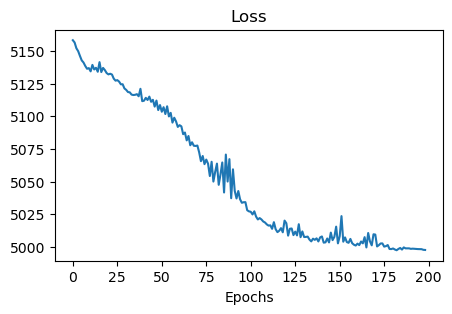

In [341]:
plt.figure(figsize=(5,3))
plt.title("Loss")
plt.xlabel("Epochs")
plt.plot(losses)
plt.show()

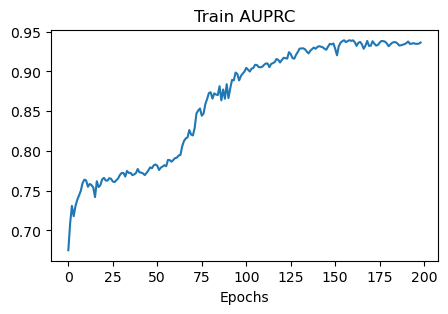

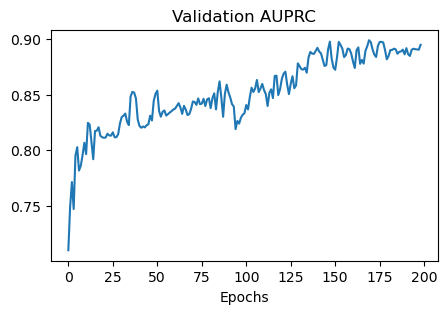

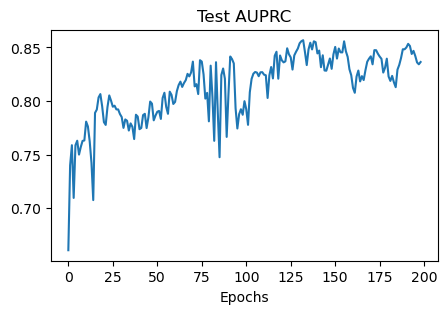

In [342]:
plt.figure(figsize=(5,3))
plt.title("Train AUPRC")
plt.plot(auprc_train)
plt.xlabel("Epochs")
plt.show()

plt.figure(figsize=(5,3))
plt.title("Validation AUPRC")
plt.xlabel("Epochs")
plt.plot(auprc_val)
plt.show()

plt.figure(figsize=(5,3))
plt.title("Test AUPRC")
plt.xlabel("Epochs")
plt.plot(auprc_test)
plt.show()

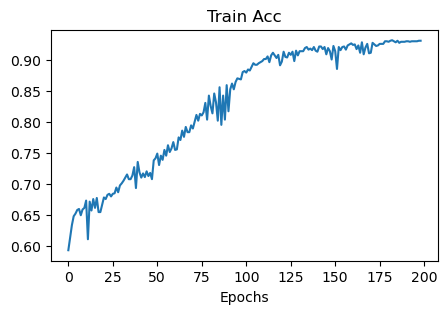

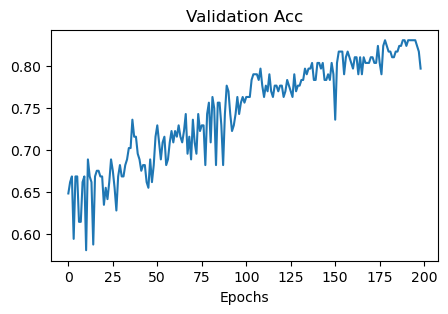

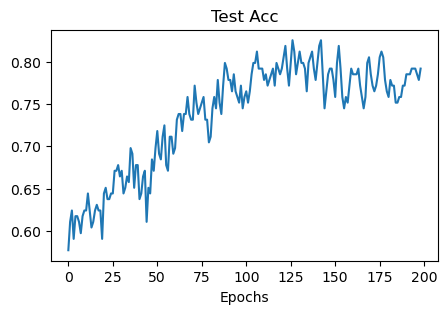

In [343]:
plt.figure(figsize=(5,3))
plt.title("Train Acc")
plt.plot(acc_train)
plt.xlabel("Epochs")
plt.show()

plt.figure(figsize=(5,3))
plt.title("Validation Acc")
plt.plot(acc_val)
plt.xlabel("Epochs")
plt.show()

plt.figure(figsize=(5,3))
plt.title("Test Acc")
plt.plot(acc_test)
plt.xlabel("Epochs")
plt.show()

## End